# Operations and modelling optimization

Maximizing profit in a dairy factory.

Showing data for ideas related to Product Management:

* Which products deliver more profit?
* Is manpower a bottleneck for further profit generation?
* Which ingredients are a bottleneck?
* How would profit look like removing ingredient bottlenecks?

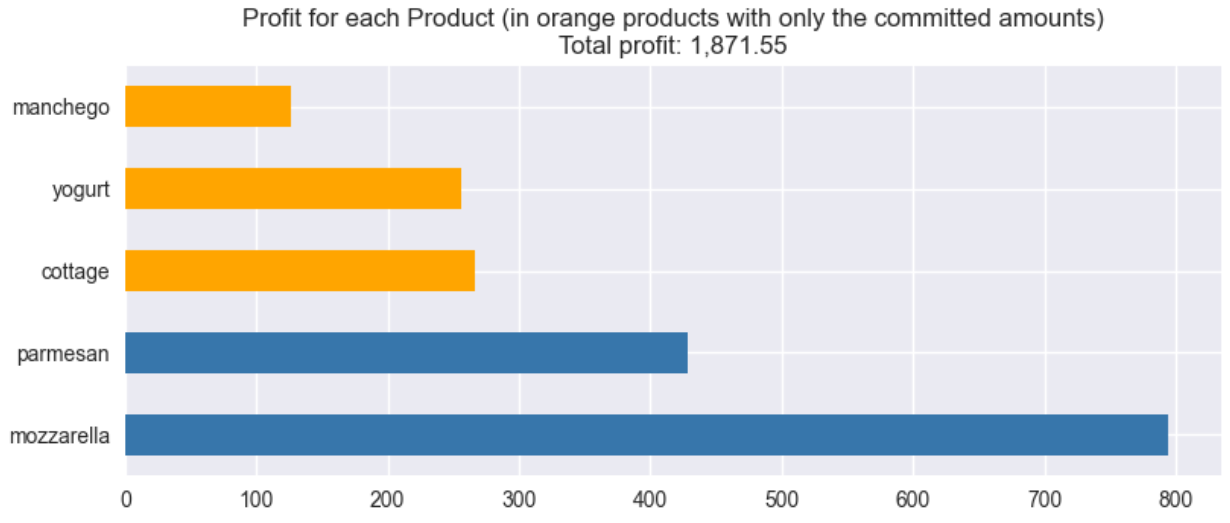

## Importing libraries

In [72]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo

import matplotlib.pyplot as plt  # Graphics (normal)
plt.style.use('seaborn-v0_8') # Style for matplotlib charts (optional, but makes easier to read charts)
plt.rcParams['figure.figsize'] = [9.3, 3.5] # Size for matplotlib charts (optional, but useful) 


## Creation of the model

A 'concrete' (normal, with data, not an abstract one with only undefined variables)

### Model initialization

In [73]:
model = pyo.ConcreteModel()

Model is created, it is empty at the very beginning

In [74]:
model.pprint()

0 Declarations: 


### Data delivered from problem reality

In [75]:
# Index I
product = ['yogurt', 'cottage', 'mozzarella', 'parmesan', 'manchego']     # Product portfolio
manpower_product = [0.05, 0.12, 0.09, 0.04, 0.16]                         # Need of manpower per product
manpower_product_total_max = 170                                          # Max. manpower available
profit_product = [0.8, 0.7, 1.15, 1.30, 0.70]                             # A profit calculation for each product of product portfolio
minimum_production_product = [320, 380, 450, 240, 180]                    # Minimum production per product

#Index J
ingredient = ['milk', 'whey', 'fat']                                      # Ingredients relevant for product portfolio analysis
availability_ingredient = [1200, 460, 650]                                # Max. availability of each ingredient

composition = [                                                           # Each row: product
               [0.7, 0.16, 0.25],                                         # Each column: ingredient
               [0.4, 0.22, 0.33],                                         # Recipe for each product
               [0.4, 0.32, 0.33],
               [0.6, 0.19, 0.4],
               [0.6, 0.23, 0.47]
              ]

### Defining sets (indices)

* Index I will be referring to products
* Index J will be referring to ingredientes

In [76]:
model.I = pyo.Set(initialize=product, doc= 'products')
model.J = pyo.Set(initialize=ingredient, doc= 'ingredients')

Just checking good progress at defining model

In [77]:
# Good practise to check evolution of model definition
# model.pprint()

### Defining parameters

* a[i]: manpower required for product i
* b[i]: profit obtained from product i
* c[j]: availability of ingredient j
* d[i, j]: composition for product i of ingredient j

In [78]:
product, manpower_product

(['yogurt', 'cottage', 'mozzarella', 'parmesan', 'manchego'],
 [0.05, 0.12, 0.09, 0.04, 0.16])

In [79]:
manpower_product_df = pd.DataFrame(manpower_product, index=product, columns=['manpower'])

In [80]:
manpower_product_df

,manpower
yogurt,0.05
cottage,0.12
mozzarella,0.09
parmesan,0.04
manchego,0.16


In [81]:
model.a = pyo.Param(model.I,
                    initialize = lambda model, i: manpower_product_df.loc[i,:].manpower,
                    doc='Manpower required for product i'
                   )

In [82]:
# Good practise to check evolution of model definition

# model.pprint()

In [83]:
profit_product_df= pd.DataFrame(profit_product, index= product, columns=['profit'])

In [84]:
profit_product_df

,profit
yogurt,0.80
cottage,0.70
mozzarella,1.15
parmesan,1.30
manchego,0.70


In [85]:
model.b = pyo.Param(model.I,
                    initialize = lambda model, i: profit_product_df.loc[i,:].profit,
                    doc='Profit from product i'
                   )

In [86]:
# Good practise to check evolution of model definition

# model.pprint()

In [87]:
availability_ingredient_df = pd.DataFrame(availability_ingredient, index= ingredient, columns=['availability'])

In [88]:
availability_ingredient_df

,availability
milk,1200
whey,460
fat,650


In [89]:
model.c = pyo.Param(model.J,
                    initialize = lambda model, j: availability_ingredient_df.loc[j,:].availability,
                    doc='Availability from ingredient j'
                   )

In [90]:
# Good practise to check evolution of model definition

# model.pprint()

In [91]:
composition_df = pd.DataFrame(composition, index=product, columns=ingredient)

In [92]:
composition_df

,milk,whey,fat
yogurt,0.7,0.16,0.25
cottage,0.4,0.22,0.33
mozzarella,0.4,0.32,0.33
parmesan,0.6,0.19,0.40
manchego,0.6,0.23,0.47


In [93]:
model.d = pyo.Param(model.I, model.J,
                    initialize = lambda model, i, j:composition_df.loc[i,j],
                    doc='composition for product i of ingredient j'
                   )

In [94]:
# Good practise to check evolution of model definition

# model.pprint()

### Defining decision variables

* X[i]: amount to produce product i

In [95]:
minimum_production_product_df = pd.DataFrame(minimum_production_product, index=product, columns=['min_amount'])

In [96]:
minimum_production_product_df

,min_amount
yogurt,320
cottage,380
mozzarella,450
parmesan,240
manchego,180


In [97]:
model.X = pyo.Var(model.I,
                  bounds=lambda model, i: (max(0, minimum_production_product_df.loc[i].min_amount), None),
                  doc='amount to produce of product i'
                 )
# Comments:
## Even with typping errors, X[i] will never be negative

In [98]:
# Good practise to check evolution of model definition

# model.pprint()

### Defining objective to optimize

Defining objective function

In [99]:
def problem_objective(model):
    output = sum(model.X[i] * model.b[i] for i in model.I)
    return output

In [100]:
model.profit = pyo.Objective(expr=problem_objective, 
                           sense=pyo.maximize,
                           doc = 'Objective function: maximize profit'
                          )

In [101]:
# Good practise to check evolution of model definition

# model.pprint()

### Defining constraints

* Maximum available time for each step j (consider supply limitations, do not overpromise to customers)

In [102]:
def manpower_constraint(model, i):
    output = sum(model.X[i] * model.a[i] for i in model.I) <= manpower_product_total_max
    return output

In [103]:
model.manpower = pyo.Constraint(model.I,
                              expr=manpower_constraint,
                              doc='total manpower constraint, be realistic with available capacity'
                             )

In [104]:
# Good practise to check evolution of model definition

# model.pprint()

In [105]:
def availability_ingredient_constraint(model, i, j):
    output = sum(model.X[i] * model.d[i, j] for i in model.I) <= model.c[j]
    return output

In [106]:
model.ingredient = pyo.Constraint(model.I, model.J,
                              expr=availability_ingredient_constraint,
                              doc='availability of ingredients constraint'
                             )

In [107]:
# Good practise to check evolution of model definition

model.pprint()

2 Set Declarations
    I : products
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'yogurt', 'cottage', 'mozzarella', 'parmesan', 'manchego'}
    J : ingredients
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'milk', 'whey', 'fat'}

4 Param Declarations
    a : Manpower required for product i
        Size=5, Index=I, Domain=Any, Default=None, Mutable=False
        Key        : Value
           cottage :  0.12
          manchego :  0.16
        mozzarella :  0.09
          parmesan :  0.04
            yogurt :  0.05
    b : Profit from product i
        Size=5, Index=I, Domain=Any, Default=None, Mutable=False
        Key        : Value
           cottage :   0.7
          manchego :   0.7
        mozzarella :  1.15
          parmesan :   1.3
            yogurt :   0.8
    c : Availability from ingredient j
        Siz

## Solving the model

Choice of solver:

* Linear programming or not: linear
* License-free (glpk or cbc for linear) or paying license (Gurobi)

In [108]:
# Pick the one you prefer for linear programming problems
# The path for executable may be different in your machine

#solver = pyo.SolverFactory('glpk', executable=r'C:\WinPy3123\glpk-4.65\w64\glpsol.exe')
solver = pyo.SolverFactory('cbc', executable=r'C:\WinPy3123\CBC\bin\cbc.exe')

# Pick this for non-linear programming problems

#solver = pyo.SolverFactory('ipopt', executable=r'C:\WinPy3123\Ipopt-3.14.19-win64-msvs2022-md\bin\ipopt.exe')

In [109]:
results = solver.solve(model)

In [110]:
print(results)


Problem: 
- Name: unknown
  Lower bound: 1871.54977
  Upper bound: 1871.54977
  Number of objectives: 1
  Number of constraints: 20
  Number of variables: 5
  Number of nonzeros: 5
  Sense: maximize
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created subproblems: None
    Black box: 
      Number of iterations: 2
  Error rc: 0
  Time: 0.046460628509521484
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [111]:
# Load results into the model
model.solutions.load_from(results)

# Print objective function value
for obj in model.component_objects(pyo.Objective, active=True):
    print(f"Objective ({obj.name}) = {pyo.value(obj):,.2f}")

# Display variable values
print()
for v in model.component_objects(pyo.Var, active=True):
    print(f"Variable: {v.name}")
    for index in v:
        print(f"  {index} = {pyo.value(v[index]):,.2f}")

# Display constraint values
print()
print("Constraint Evaluations:")
for c in model.component_objects(pyo.Constraint, active=True):
    print()
    print(f" Constraint: {c.name}")
    for index in c:
        body_value = pyo.value(c[index].body)
        lower = c[index].lower
        upper = c[index].upper
        print(f"  {index}: {body_value:,.2f} ∈ [{lower}, {upper}]")


Objective (profit) = 1,871.55

Variable: X
  yogurt = 320.00
  cottage = 380.00
  mozzarella = 690.96
  parmesan = 329.95
  manchego = 180.00

Constraint Evaluations:

 Constraint: manpower
  yogurt: 165.78 ∈ [None, 170.0]
  cottage: 165.78 ∈ [None, 170.0]
  mozzarella: 165.78 ∈ [None, 170.0]
  parmesan: 165.78 ∈ [None, 170.0]
  manchego: 165.78 ∈ [None, 170.0]

 Constraint: ingredient
  ('yogurt', 'milk'): 958.36 ∈ [None, 1200.0]
  ('yogurt', 'whey'): 460.00 ∈ [None, 460.0]
  ('yogurt', 'fat'): 650.00 ∈ [None, 650.0]
  ('cottage', 'milk'): 958.36 ∈ [None, 1200.0]
  ('cottage', 'whey'): 460.00 ∈ [None, 460.0]
  ('cottage', 'fat'): 650.00 ∈ [None, 650.0]
  ('mozzarella', 'milk'): 958.36 ∈ [None, 1200.0]
  ('mozzarella', 'whey'): 460.00 ∈ [None, 460.0]
  ('mozzarella', 'fat'): 650.00 ∈ [None, 650.0]
  ('parmesan', 'milk'): 958.36 ∈ [None, 1200.0]
  ('parmesan', 'whey'): 460.00 ∈ [None, 460.0]
  ('parmesan', 'fat'): 650.00 ∈ [None, 650.0]
  ('manchego', 'milk'): 958.36 ∈ [None, 1200.0]
  

# Analyzing results

## Products delivering more profitability?

In [112]:
X_optimum = [pyo.value(model.X[i]) for i in model.X]

In [113]:
X_optimum

[320.0, 380.0, 690.96478, 329.95406, 180.0]

In [114]:
profit_product_df

,profit
yogurt,0.80
cottage,0.70
mozzarella,1.15
parmesan,1.30
manchego,0.70


In [115]:
profit_product_df['amount_optimum'] = X_optimum

In [116]:
profit_product_df['profit_optimum'] = profit_product_df.profit * profit_product_df.amount_optimum

Checking that everything is fine

In [117]:
profit_product_df.profit_optimum.sum() == pyo.value(model.profit)

True

In [118]:
profit_product_df['committed_amount'] = minimum_production_product

In [119]:
profit_product_df['is_amount_committed'] = round(profit_product_df.committed_amount,2) ==\
                                           round(profit_product_df.amount_optimum,2)

In [120]:
profit_product_df

,profit,amount_optimum,profit_optimum,committed_amount,is_amount_committed
yogurt,0.80,320.00000,256.000000,320,True
cottage,0.70,380.00000,266.000000,380,True
mozzarella,1.15,690.96478,794.609497,450,False
parmesan,1.30,329.95406,428.940278,240,False
manchego,0.70,180.00000,126.000000,180,True


### Plotting analysis results

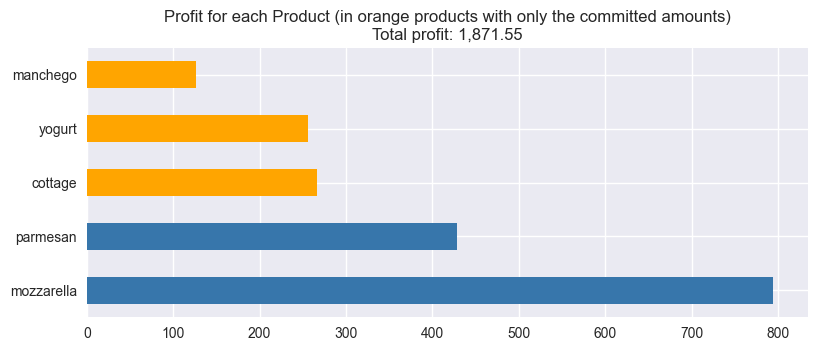


Results:
 Total profit: 1,871.55


,profit,amount_optimum,profit_optimum,committed_amount,is_amount_committed
mozzarella,1.15,690.96,794.61,450.00,0.00
parmesan,1.30,329.95,428.94,240.00,0.00
cottage,0.70,380.00,266.00,380.00,1.00
yogurt,0.80,320.00,256.00,320.00,1.00
manchego,0.70,180.00,126.00,180.00,1.00


In [121]:
query = profit_product_df.sort_values(by='profit_optimum', ascending=False)
colors = ['orange' if b else '#3776ab' for b in query.is_amount_committed]
query.profit_optimum.plot(kind='barh', color=colors)
plt.title(f'Profit for each Product (in orange products with only the committed amounts)\nTotal profit: {pyo.value(model.profit):,.2f}')
plt.show()
print('\nResults:')
print(f' Total profit: {pyo.value(model.profit):,.2f}')
display(profit_product_df.sort_values(by='profit_optimum', ascending=False).style.format("{:,.2f}"))

## Is manpower a bottleneck for further profitability?

In [122]:
manpower_product_df

,manpower
yogurt,0.05
cottage,0.12
mozzarella,0.09
parmesan,0.04
manchego,0.16


In [123]:
manpower_product_df['amount_optimum'] = X_optimum

manpower_product_df['manpower_optimum'] = manpower_product_df.manpower * manpower_product_df.amount_optimum

In [124]:
manpower_product_df

,manpower,amount_optimum,manpower_optimum
yogurt,0.05,320.00000,16.000000
cottage,0.12,380.00000,45.600000
mozzarella,0.09,690.96478,62.186830
parmesan,0.04,329.95406,13.198162
manchego,0.16,180.00000,28.800000


Checking that everything is fine

In [125]:
manpower_product_df.manpower_optimum.sum() == \
                    pyo.value(model.manpower[product[0]]) # I could have chosen any product

True

### Plotting analysis results

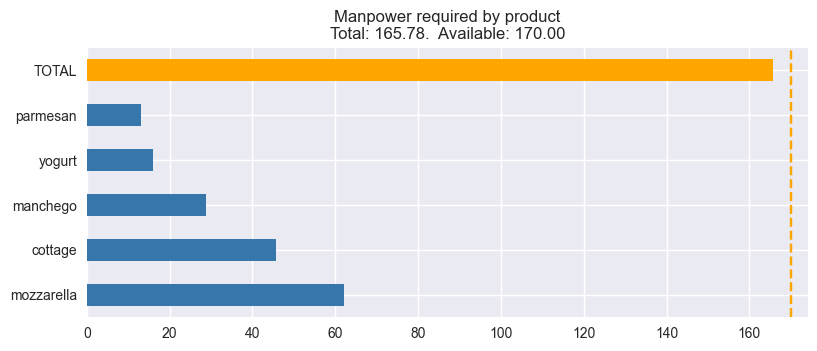


Results:
 Required: 165.78
 Available: 170.00


,manpower,amount_optimum,manpower_optimum
mozzarella,0.09,690.96,62.19
cottage,0.12,380.00,45.60
manchego,0.16,180.00,28.80
yogurt,0.05,320.00,16.00
parmesan,0.04,329.95,13.20


In [126]:
query = manpower_product_df.manpower_optimum.sort_values(ascending=False)
query['TOTAL'] = query.sum()
colors = ['orange' if b == 'TOTAL' else '#3776ab' for b in query.index]
query.plot(kind='barh', color=colors)
plt.axvline(x=manpower_product_total_max, linestyle='--', color='orange')
plt.title(f'Manpower required by product\nTotal: {query.TOTAL:,.2f}.  Available: {manpower_product_total_max:,.2f}')
plt.show()
print(f'\nResults:\n Required: {query.TOTAL:,.2f}\n Available: {manpower_product_total_max:,.2f}')
display(manpower_product_df.sort_values(by='manpower_optimum', ascending=False).style.format("{:,.2f}"))

## Which ingredients are a bottleneck for further profitability?

In [127]:
availability_ingredient_df

,availability
milk,1200
whey,460
fat,650


In [128]:
index_list = list(range(len(model.J)))
index_list

[0, 1, 2]

In [129]:
demand_optimum = [pyo.value(model.ingredient[product[0], ingredient[j]].body) for j in index_list]

In [130]:
demand_optimum

[958.358348, 460.000001, 650.0000014000001]

In [131]:
availability_ingredient_df['demand_optimum'] = demand_optimum

In [132]:
availability_ingredient_df['is_bottleneck'] = round(availability_ingredient_df.availability, 2) ==\
                                              round(availability_ingredient_df.demand_optimum, 2)

In [133]:
availability_ingredient_df

,availability,demand_optimum,is_bottleneck
milk,1200,958.358348,False
whey,460,460.000001,True
fat,650,650.000001,True


### Plotting analysis results

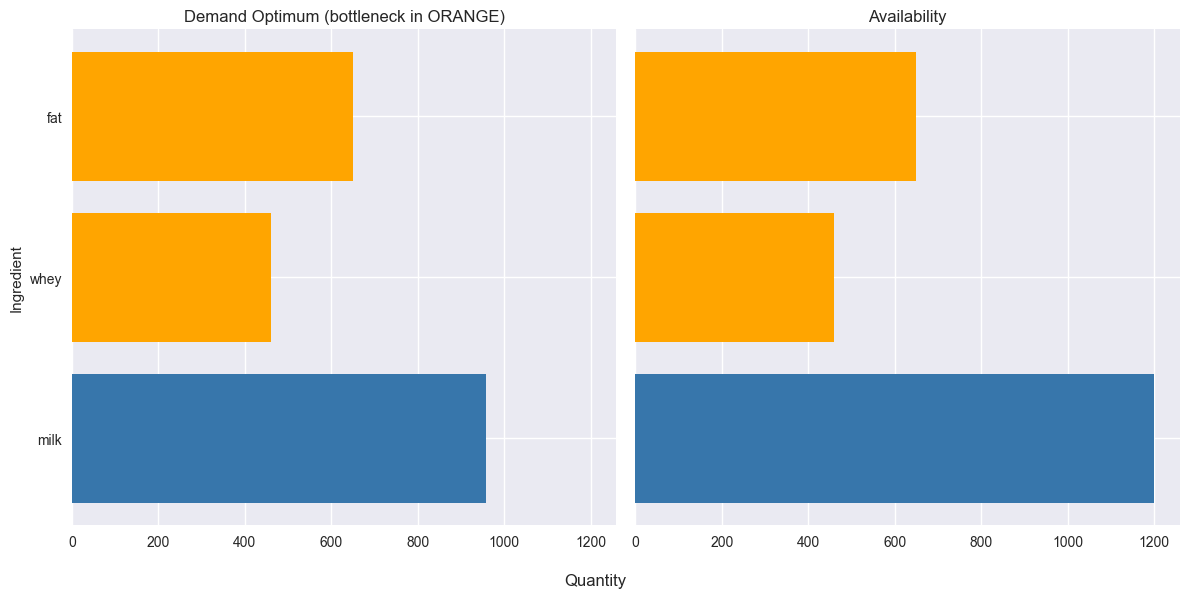


Results:


,availability,demand_optimum,is_bottleneck
milk,"1,200.00",958.36,0.00
whey,460.00,460.00,1.00
fat,650.00,650.00,1.00


In [134]:
# Create subplots: 1 row, 2 columns, shared x-axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

colors = ['orange' if b else '#3776ab' for b in availability_ingredient_df.is_bottleneck]

# First chart: Demand Optimum
axes[0].barh(availability_ingredient_df.index, availability_ingredient_df.demand_optimum, color=colors)
axes[0].set_title('Demand Optimum (bottleneck in ORANGE)')
axes[0].set_ylabel('Ingredient')
axes[0].invert_yaxis()  # Optional: keeps order consistent

# Second chart: Availability
axes[1].barh(availability_ingredient_df.index, availability_ingredient_df.availability, color=colors)
axes[1].set_title('Availability')
axes[1].invert_yaxis()

# Shared x-axis label
fig.supxlabel('Quantity')

# Layout adjustment
plt.tight_layout()
plt.show()
print('\nResults:')
display(availability_ingredient_df.style.format("{:,.2f}"))

## Bonus: what is the profit removing the bottleneck detected among the ingredients?

### Solution

Run the code again, modifying the variable: 
* availability_ingredient = [1200, 4600, 6500] 

(Just add very high values to the variables which are bottlenecks)

Here the results (screenshots):

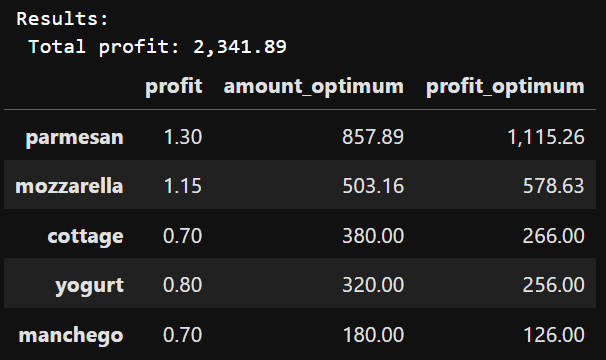

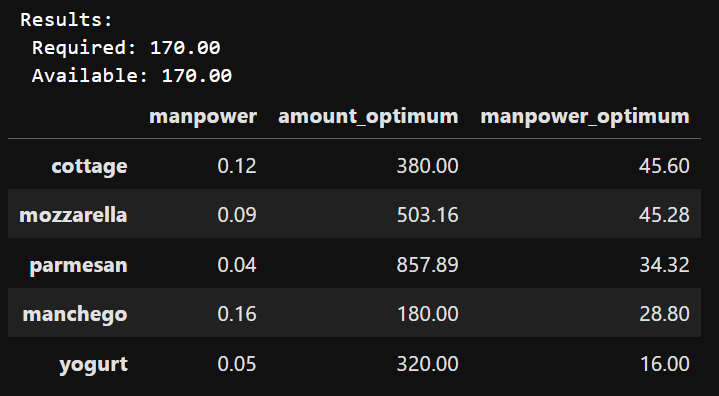

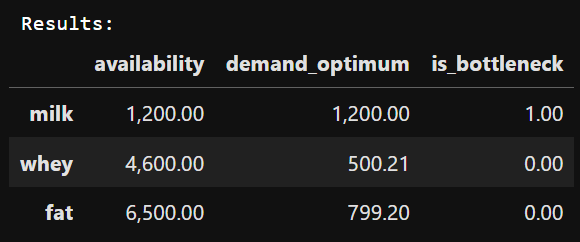

Comments:

* Really a significant difference in profit (increasing around 25%)
* Not compromising current manpower availability (increased less than 3%, within current limit)
* The required increase of whey is relatively small, in theory easy to address (increased less than 9%)
* Attention should be taken about the reason of the lack of fat (required increase of almost 23%)
* In terms of portfolio management, attention should be taken to the commitments done to supply the low-value products and try to reduce their production levels in order to produce more high-value products... this should be analysed more in detail, considering product life cycle, market environment and other risks